# Galsim GAN demo

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import sys
sys.path.append('../')
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Create a galaxy dataset from GalSim

In [4]:
import galsim

In [5]:
cat = galsim.COSMOSCatalog(dir='/usr/local/share/galsim/COSMOS_25.2_training_sample',
                           file_name='real_galaxy_catalog_25.2.fits')

In [6]:
from deepgal.galsim import get_postage_stamp_map
from multiprocessing import Pool
import tensorflow as tf

In [7]:
pool=None

In [247]:
def training_func():
    dset = tf.data.Dataset.from_tensor_slices(cat.orig_index).batch(128).map(get_postage_stamp_map(cat.real_cat,stamp_size=32, pixel_size=0.06, pool=pool))
    dset = dset.flat_map(lambda arg, *rest: tf.data.Dataset.from_tensor_slices((arg,) + rest))
    dset = dset.repeat(2).cache('/data2/cosmos_cache/cache32')
    dset = dset.repeat().shuffle(buffer_size=20000).batch(64).prefetch(16)
    iterator = dset.make_one_shot_iterator()
    batch_im, batch_psf, batch_ps = iterator.get_next()
    return {'noise':tf.random_normal(shape=(64,128)), 'psf':batch_psf, 'ps':batch_ps}, tf.reshape(batch_im,(64,32,32,1))

In [248]:
def testing_func():
    dset = tf.data.Dataset.from_tensor_slices(cat.orig_index).batch(128).map(get_postage_stamp_map(cat.real_cat,stamp_size=32, pixel_size=0.06, pool=pool))
    dset = dset.flat_map(lambda arg, *rest: tf.data.Dataset.from_tensor_slices((arg,) + rest))
    dset = dset.repeat(2).cache('/data2/cosmos_cache/cache32')
    dset = dset.repeat().shuffle(buffer_size=20000).batch(64).prefetch(16)
    iterator = dset.make_one_shot_iterator()
    batch_im, batch_psf, batch_ps = iterator.get_next()
    return {'noise': tf.random_normal(shape=(64,128)), 'psf':batch_psf, 'ps':batch_ps}

## Builds TFGAN model

In [49]:
import tensorflow.contrib.gan as tfgan

# Shortcuts for later.
layers = tf.contrib.layers
framework = tf.contrib.framework

In [198]:
def generator_fn(inputs, weight_decay=2.5e-5, is_training=True):
    """Simple generator 
    
    Args:
        noise: A single Tensor representing noise.
        weight_decay: The value of the l2 weight decay.
        is_training: If `True`, batch norm uses batch statistics. If `False`, batch
            norm uses the exponential moving average collected from population 
            statistics.
    
    Returns:
        A generated image in the range [-1, 1].
    """
    noise = inputs['noise']
    psf = inputs['psf']
    ps = inputs['ps']

    with framework.arg_scope(
        [layers.fully_connected, layers.conv2d_transpose],
        activation_fn=tf.nn.relu, normalizer_fn=layers.batch_norm,
        weights_regularizer=layers.l2_regularizer(weight_decay)),\
    framework.arg_scope([layers.batch_norm], is_training=is_training,
                        zero_debias_moving_mean=True):
        net = layers.fully_connected(noise, 1024)
        net = layers.fully_connected(net, 8 * 8 * 256)
        net = tf.reshape(net, [-1, 8, 8, 256])
        net = layers.conv2d_transpose(net, 64, [4, 4], stride=2)
        net = layers.conv2d_transpose(net, 32, [4, 4], stride=2)
        
        # Make sure that generator output is in the same range as `inputs`
        # ie [-1, 1].
        before_psf = layers.conv2d(net, 1, 4, normalizer_fn=None, activation_fn=None)
        
        # Apply PSF
        x = tf.spectral.rfft2d(tf.squeeze(before_psf))
        x = x * psf
        
        # Creates a noise realisation
        n = tf.squeeze(tf.random_normal(before_psf.shape))
        n = tf.spectral.rfft2d(n) * tf.complex(tf.sqrt(tf.exp(ps)),0*tf.sqrt(tf.exp(ps)))
    
        # Recover pixel space image
        x = tf.expand_dims(tf.spectral.irfft2d(x + n),axis=-1)
        return x
    
def discriminator_fn(img, unused_conditioning, weight_decay=2.5e-5,
                     is_training=True):
    """Discriminator network on MNIST digits.
    
    Args:
        img: Real or generated MNIST digits. Should be in the range [-1, 1].
        unused_conditioning: The TFGAN API can help with conditional GANs, which
            would require extra `condition` information to both the generator and the
            discriminator. Since this example is not conditional, we do not use this
            argument.
        weight_decay: The L2 weight decay.
        is_training: If `True`, batch norm uses batch statistics. If `False`, batch
            norm uses the exponential moving average collected from population 
            statistics.
    
    Returns:
        Logits for the probability that the image is real.
    """
    print(img)
    with framework.arg_scope(
        [layers.conv2d, layers.fully_connected],
        activation_fn=tf.nn.leaky_relu, normalizer_fn=None,
        weights_regularizer=layers.l2_regularizer(weight_decay),
        biases_regularizer=layers.l2_regularizer(weight_decay)):
        net = layers.conv2d(img, 64, [4, 4], stride=2)
        net = layers.conv2d(net, 128, [4, 4], stride=2)
        net = layers.flatten(net)
        with framework.arg_scope([layers.batch_norm], is_training=is_training):
            net = layers.fully_connected(net, 1024, normalizer_fn=layers.batch_norm)
        return layers.linear(net, 1)

In [199]:
inputs,img = training_func()

In [200]:
test = generator_fn(inputs)

In [201]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [202]:
i,i0 = sess.run([test,img])

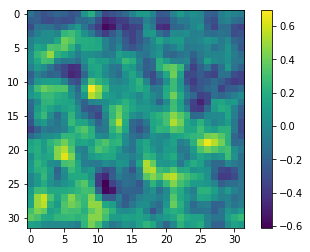

In [203]:
imshow(i[0,:,:,0]);colorbar()

In [236]:
config = tf.estimator.RunConfig(save_checkpoints_steps=1000)

# Initialize GANEstimator with options and hyperparameters.
gan_estimator = tfgan.estimator.GANEstimator(
    generator_fn=generator_fn,
    discriminator_fn=discriminator_fn,
    generator_loss_fn=tfgan.losses.wasserstein_generator_loss,
    discriminator_loss_fn=lambda *args, **kwargs: (tfgan.losses.wasserstein_discriminator_loss(*args, **kwargs) + 
                                                   10.*tfgan.losses.wasserstein_gradient_penalty(*args, **kwargs)),
    generator_optimizer=tf.train.AdamOptimizer(0.001, 0.5),
    discriminator_optimizer=tf.train.AdamOptimizer(0.0001, 0.5),
    add_summaries=tfgan.estimator.SummaryType.IMAGES,
    model_dir='/data2/galsimgan/model5',
    config=config)

INFO:tensorflow:Using config: {'_model_dir': '/data2/galsimgan/model5', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f937ed264a8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [249]:
gan_estimator.train(training_func, steps=10000)

INFO:tensorflow:Calling model_fn.
Tensor("Generator/ExpandDims:0", shape=(64, 32, 32, 1), dtype=float32)
Tensor("Reshape:0", shape=(64, 32, 32, 1), dtype=float32, device=/device:CPU:0)
INFO:tensorflow:Summary name Generator/fully_connected/weights:0 is illegal; using Generator/fully_connected/weights_0 instead.
INFO:tensorflow:Summary name Generator/fully_connected/BatchNorm/beta:0 is illegal; using Generator/fully_connected/BatchNorm/beta_0 instead.
INFO:tensorflow:Summary name Generator/fully_connected_1/weights:0 is illegal; using Generator/fully_connected_1/weights_0 instead.
INFO:tensorflow:Summary name Generator/fully_connected_1/BatchNorm/beta:0 is illegal; using Generator/fully_connected_1/BatchNorm/beta_0 instead.
INFO:tensorflow:Summary name Generator/Conv2d_transpose/weights:0 is illegal; using Generator/Conv2d_transpose/weights_0 instead.
INFO:tensorflow:Summary name Generator/Conv2d_transpose/BatchNorm/beta:0 is illegal; using Generator/Conv2d_transpose/BatchNorm/beta_0 in

KeyboardInterrupt: 

In [250]:
preds = gan_estimator.predict(testing_func, yield_single_examples=False)

In [251]:
ims  = next(preds)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data2/galsimgan/model5/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [252]:
print(ims.shape)

(64, 32, 32, 1)


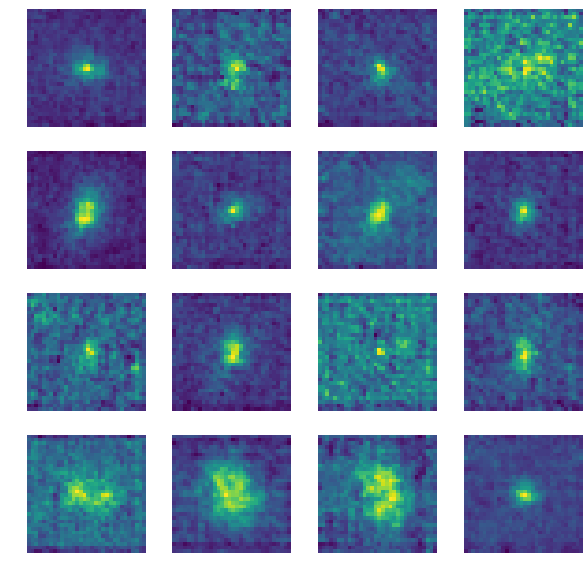

In [246]:
figure(figsize=(10,10))
for i in range(16):
    subplot(4,4,i+1)
    imshow(ims[i,:,:,0])
    axis('off')